In [29]:
import pandas as pd
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import trackpy as tp
import math
# from scipy.stats import hypergeom

In [47]:
def get_angle_and_arc(traj, order_pNo):
    data = pd.DataFrame()
    for frame in traj.frame.drop_duplicates():
        subtraj = traj.loc[traj.frame==frame]        
        count = 0
        bond_length = 0
        theta = []
        s = []
        k = 0
        for i in order_pNo:
            if k == 0:
                try:
                    x1 = subtraj.x.loc[subtraj.particle==i].values[0]
                    y1 = subtraj.y.loc[subtraj.particle==i].values[0]
                    xt = x1
                    yt = y1
                    k += 1 # make sure we have particle 1
                    continue
                except:
                    continue
            x2 = subtraj.x.loc[subtraj.particle==i].values[0]
            y2 = subtraj.y.loc[subtraj.particle==i].values[0]
            theta.append(np.arctan((y2-y1)/(x2-x1)))
            bond_length += ((y2-yt)**2 + (x2-xt)**2)**.5
            s.append(bond_length)
            xt = x2
            yt = y2
        subdata = pd.DataFrame().assign(s=s, theta=theta, frame=frame)
        data = data.append(subdata)
    return data

In [11]:
traj = pd.read_csv(r'R:\Dip\DNA_chain\fluorescent\substack_lp\tracking.csv')
order_pNo = np.array([0,1,2,3,4,5,6])
aaa = get_angle_and_arc(traj, order_pNo)

In [122]:
data1

,s,theta,frame
0,31.912217,-0.269773,1
1,65.552701,-0.516954,1
2,99.696777,-0.507185,1
3,131.949888,-0.474057,1
4,164.331266,-0.448824,1
5,196.583275,-0.452008,1
0,33.459280,-0.279700,2
1,67.393147,-0.518862,2
2,102.155065,-0.517483,2
3,134.460589,-0.495552,2


In [45]:
aaa.to_csv(r'R:\Dip\DNA_chain\fluorescent\substack_lp\arc_and_angle.csv')

* Compute fourier expansion coefficients

In [46]:
def fourier_coef(data, n=10): # in unit same as input data (usually pixel)
    # data is pd.DataFrame containing theta and arc_length
    # n is number of expanded terms
    L = data.s.max() + data.s.min()
    data = data.assign(ds=data.s.diff())
    a = []
    for i in range(0, n):
        coef = 0
        for num, r in data.iterrows():
            if num == 0:
                coef += r.theta * np.cos(i*np.pi*r.s/2/L) * r.s 
                continue            
            coef += r.theta * np.cos(i*np.pi*(r.s-r.ds/2)/L) * r.ds 
        coef = coef * (2 / L)**0.5
        a.append(coef)
    return np.array(a)

In [2]:
data1 = pd.read_csv(r'E:\Github\Python\mylib\xiaolei\chain\test_files\lp\arc_and_angle.csv', index_col=0)
data = data1.loc[data1.frame==1]
coef = fourier_coef(data, n=12)
coef

In [ ]:
# Iterate over all images

In [49]:
data_all = pd.DataFrame()
for frame in data1.frame.drop_duplicates():
    subdata = data1.loc[data1.frame==frame]
    a = fourier_coef(subdata, n=12)
    subdata = pd.DataFrame().assign(a=a, frame=frame)
    data_all = data_all.append(subdata)

In [104]:
def corrT(autocorr_data):
    # Calculate temporal correlation function
    # autocorr_data is a pd.DataFrame containing columns (Name, ac)
    length = len(autocorr_data)
    autocorr_data.ac = autocorr_data.ac - autocorr_data.ac.mean()
    Isq = (np.array(autocorr_data.ac)**2).sum() / length
    C = np.zeros((length, 1)).squeeze()
    t = np.zeros((length, 1)).squeeze()
    for tin in range(0, length):
        count = 0
        Ct = 0
        for ts in range(0, length-tin):
            d1 = autocorr_data.loc[ts]
            d2 = autocorr_data.loc[ts+tin]
            Ct += d2.ac*d1.ac
            count += 1
        Ct = Ct / count / Isq
        C[tin] = Ct
        t[tin] = tin
    return pd.DataFrame().assign(dt=t, C=C)

In [105]:
subdata = data_all.loc[0]
acdata = subdata.rename(columns={'a': 'ac', 'frame': 'Name'}).reset_index()

Text(0, 0.5, '$a_1$')

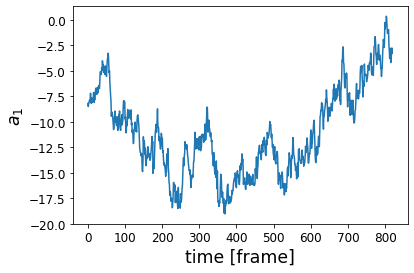

In [111]:
plt.plot(subdata.frame, subdata.a)
plt.xlabel('time [frame]')
plt.ylabel('$a_1$')

In [106]:
ac = corrT(acdata.loc[acdata.Name<200])

E:\anaconda\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Text(0, 0.5, 'Autocorrelation')

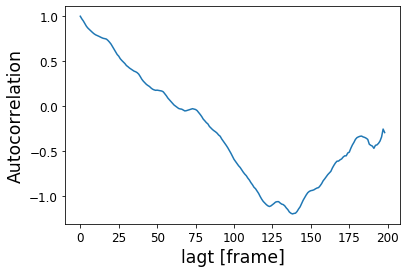

In [108]:
plt.plot(ac.dt, ac.C)
plt.xlabel('lagt [frame]')
plt.ylabel('Autocorrelation')

In [59]:
dt = 100
varan = []
for i in data_all.index.drop_duplicates():
    print('a' + str(i))
    varan_tmp = 0
    count = 0
    for t in range(1, 700):
        an1 = data_all.loc[data_all.frame==t].loc[i].a
        an2 = data_all.loc[data_all.frame==t+dt].loc[i].a
        varan_tmp += (an2 - an1)**2
        count += 1
    varan_tmp /= count
    varan.append(varan_tmp)

a0
a1
a2
a3
a4
a5
a6
a7
a8
a9
a10
a11


Text(0, 0.5, 'Var(a$_n$)')

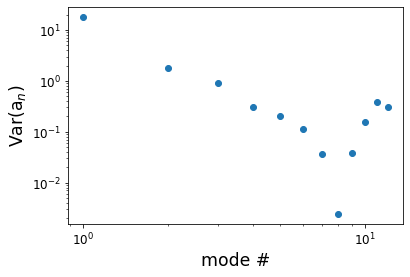

In [63]:
plt.plot(range(1, 13), varan, marker='o', ls='')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('mode #')
plt.ylabel('Var(a$_n$)')

<script src="https://polyfill.io/v3/polyfill.min.js?features=es6"></script>
<script id="MathJax-script" async src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js"></script>
* Fit the first 7 points with power law
$$\text{var}(a_n) = \frac{L^2}{n^2\pi^2l_p}$$
$$l_p = \frac{L^2}{n^2\pi^2\text{var}(a_n)}$$
$$ \ln \text{var} =  \ln\frac{L^2}{\pi^2l_p} - 2\ln n$$

In [86]:
from scipy.optimize import curve_fit
def power(x, a):
    return a/np.power(x, 2)
fitx = np.array(range(1, 8))
fity = varan[0: 7]
popt, pcov = curve_fit(power, fitx, fity, p0 = 1)

Text(0, 0.5, 'Var(a$_n$)')

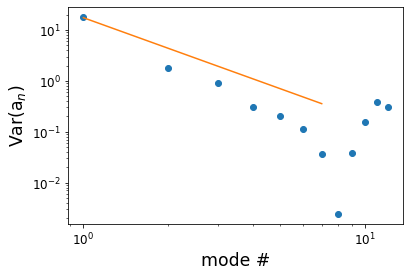

In [87]:
plt.plot(range(1, 13), varan, marker='o', ls='')
plt.plot(fitx, power(fitx, *popt))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('mode #')
plt.ylabel('Var(a$_n$)')

In [2]:
# Take log and linear fit
def lin(x, a):
    return -2 * x + a
fitx = np.log(np.array(range(1, 8)))
fity = np.log(varan[0: 7])
po, pc = curve_fit(lin, fitx, fity, p0=1)

NameError: name 'varan' is not defined

Text(0, 0.5, 'Var(a$_n$)')

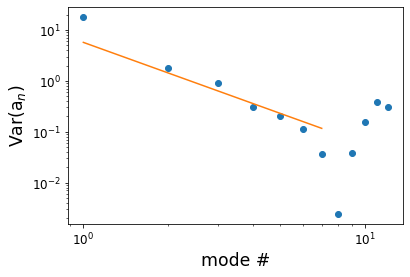

In [101]:
plt.plot(range(1, 13), varan, marker='o', ls='')
plt.plot(np.exp(fitx), np.exp(lin(fitx, *po)))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('mode #')
plt.ylabel('Var(a$_n$)')

$$l_p=\frac{L^2}{\pi^2\exp\text{intersect}}$$

In [115]:
L = data1.s.max() + data1.s.min()

In [117]:
lp = L**2 / np.pi**2 / np.exp(po)

$$l_p=948\text{ px}$$

In [22]:
order_pNo = np.array([0,1,2,3,4,5,6])
count = 0
k = 0
bond_length = 0
theta = []
s = []
for i in order_pNo:
    if k == 0:
        try:
            x1 = traj.x.loc[traj.particle==i].values[0]
            y1 = traj.y.loc[traj.particle==i].values[0]
            xt = x1
            yt = y1
            k += 1
            continue
        except:
            continue
    x2 = traj.x.loc[traj.particle==i].values[0]
    y2 = traj.y.loc[traj.particle==i].values[0]
    theta.append(np.arctan((y2-y1)/(x2-x1)))
    bond_length += ((y2-yt)**2 + (x2-xt)**2)**.5
    s.append(bond_length)
    xt = x2
    yt = y2

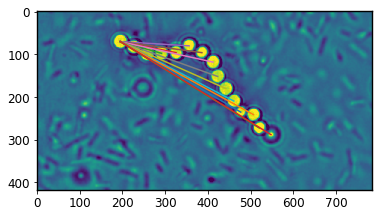

In [25]:
count = 0
k = 0
theta = []
plt.imshow(img)
for i in order_pNo:
    if k == 0:
        try:
            xt = traj.x.loc[traj.particle==i].values[0]
            yt = traj.y.loc[traj.particle==i].values[0]
            k += 1
            continue
        except:
            continue
    x2 = traj.x.loc[traj.particle==i].values[0]
    y2 = traj.y.loc[traj.particle==i].values[0]
    plt.plot([xt, x2], [yt, y2])

# 2D-radial-distribution

In [53]:
def wlc_distribution_2D(k, deltaX=0.001):    
    num = np.floor(1/deltaX)
    r = np.linspace(0, 1, num=num)
    n = len(r)
    r_m = 1/5/k
    
    t = 1
    C = 1
    q = []
    P = []
    count = 1
    for r1 in r:
        r_bar = 1 - r1
        if r_bar > r_m:
            q1 = np.pi*k/2*np.exp(-np.pi**2*k*r_bar)            
            print('Inner shell, i = {:d}'.format(count))
        else:
            print('Outer shell, i = {:d}'.format(count))
            if count > 2 and t == 1:
                q1 = k/np.pi/np.sqrt(np.pi)/((2*k*r_bar)**(5/4))*np.exp(-0.25**2/(2*k*r_bar))*dfunc(0.5/np.sqrt(2*k*r_bar))
                q_extroploate = 2*q[len(q)-1]*q[len(q)-2]
                C = q_extroploate / q1
                q1 = q_extroploate
                t = 0
            else:
                q1 = C*k/np.pi/np.sqrt(np.pi)/((2*k*r_bar)**(5/4))*np.exp(-0.25**2/(2*k*r_bar))*dfunc(0.5/np.sqrt(2*k*r_bar))
        q.append(q1)
        P1 = q1*4*np.pi*r1**2
        P.append(P1)
        count += 1
    return r, P

In [40]:
def dfunc(x):
    a = 1.5
    b = np.cos(np.pi*a/2)*math.gamma(5/4)*hypergeom(-a/2, 0.5, x**2/2)
    c = np.sqrt(2)*x*np.sin(np.pi*a/2)*math.gamma(7/4)*hypergeom(-0.25, 1.5, x**2/2)
    y = 2**(a/2)/np.sqrt(np.pi)*np.exp(-x**2/4)*(b+c)
    return y

In [58]:
def hypergeom(a, b, z):
    n = 100
    h = 0
    for i in range(0, n):
        h += pochhammer(a, i) / pochhammer(b, i) * z**i / math.factorial(i)
    return h

In [30]:
def pochhammer(x, n):
    return math.gamma(x+n)/math.gamma(x)

In [59]:
r, P = wlc_distribution_2D(1)

E:\anaconda\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


Inner shell, i = 1
Inner shell, i = 2
Inner shell, i = 3
Inner shell, i = 4
Inner shell, i = 5
Inner shell, i = 6
Inner shell, i = 7
Inner shell, i = 8
Inner shell, i = 9
Inner shell, i = 10
Inner shell, i = 11
Inner shell, i = 12
Inner shell, i = 13
Inner shell, i = 14
Inner shell, i = 15
Inner shell, i = 16
Inner shell, i = 17
Inner shell, i = 18
Inner shell, i = 19
Inner shell, i = 20
Inner shell, i = 21
Inner shell, i = 22
Inner shell, i = 23
Inner shell, i = 24
Inner shell, i = 25
Inner shell, i = 26
Inner shell, i = 27
Inner shell, i = 28
Inner shell, i = 29
Inner shell, i = 30
Inner shell, i = 31
Inner shell, i = 32
Inner shell, i = 33
Inner shell, i = 34
Inner shell, i = 35
Inner shell, i = 36
Inner shell, i = 37
Inner shell, i = 38
Inner shell, i = 39
Inner shell, i = 40
Inner shell, i = 41
Inner shell, i = 42
Inner shell, i = 43
Inner shell, i = 44
Inner shell, i = 45
Inner shell, i = 46
Inner shell, i = 47
Inner shell, i = 48
Inner shell, i = 49
Inner shell, i = 50
Inner she

Outer shell, i = 864
Outer shell, i = 865
Outer shell, i = 866
Outer shell, i = 867
Outer shell, i = 868
Outer shell, i = 869
Outer shell, i = 870
Outer shell, i = 871
Outer shell, i = 872
Outer shell, i = 873
Outer shell, i = 874
Outer shell, i = 875
Outer shell, i = 876
Outer shell, i = 877
Outer shell, i = 878
Outer shell, i = 879
Outer shell, i = 880
Outer shell, i = 881
Outer shell, i = 882
Outer shell, i = 883
Outer shell, i = 884
Outer shell, i = 885
Outer shell, i = 886
Outer shell, i = 887
Outer shell, i = 888
Outer shell, i = 889
Outer shell, i = 890
Outer shell, i = 891
Outer shell, i = 892
Outer shell, i = 893
Outer shell, i = 894
Outer shell, i = 895
Outer shell, i = 896
Outer shell, i = 897
Outer shell, i = 898
Outer shell, i = 899
Outer shell, i = 900
Outer shell, i = 901
Outer shell, i = 902
Outer shell, i = 903
Outer shell, i = 904
Outer shell, i = 905
Outer shell, i = 906
Outer shell, i = 907
Outer shell, i = 908
Outer shell, i = 909
Outer shell, i = 910
Outer shell, 

E:\anaconda\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
E:\anaconda\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
E:\anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


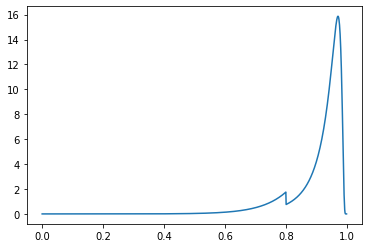

In [60]:
plt.plot(r, P)

In [67]:
x = np.linspace(-1, 1)
y = []
for xx in x:
    y.append(dfunc(xx))

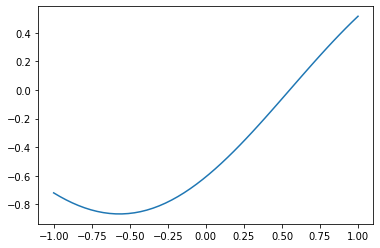

In [68]:
plt.plot(x, y)